# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


In [6]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [7]:
X = raw_df.values[::2, :]
y = raw_df.values[1::2, 2]

In [8]:
X.shape, y.shape

((506, 11), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [9]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.865921976373926

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [124]:
import numpy as np
from sklearn.utils import resample

def compute_biase_variance(regressor, X, y, num_runs=1000):
    
    preds_oob_sum = np.zeros(X.shape[0])
    sq_preds_oob_sum = np.zeros(X.shape[0])
    cnt_oob = np.zeros(X.shape[0])
    all_error = 0

    for _ in range(num_runs):
        idx = resample(np.arange(X.shape[0]))
        out_of_bag = np.delete(np.arange(X.shape[0]), idx)

        X_train = X[idx].copy()
        y_train = y[idx].copy()
        X_test = X[out_of_bag].copy()
        y_test = y[out_of_bag].copy()

        regressor.fit(X_train, y_train)
        preds = regressor.predict(X_test)

        preds_oob_sum[out_of_bag] += preds
        sq_preds_oob_sum[out_of_bag] += preds**2
        cnt_oob[out_of_bag] += 1

        all_error += np.sum((y_test - preds) ** 2)

    preds_true = cnt_oob > 0
    bias = np.mean(((preds_oob_sum[preds_true] / cnt_oob[preds_true]) - y[preds_true]) ** 2)
    variance = np.mean((sq_preds_oob_sum[preds_true] / cnt_oob[preds_true]) - ((preds_oob_sum[preds_true] / cnt_oob[preds_true]) ** 2))
    error = all_error / np.sum(cnt_oob)

    return bias, variance, error


__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [125]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
compute_biase_variance(lr, X, y)

(29.51284556945257, 0.8837674659359028, 30.205317739087338)

In [126]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
compute_biase_variance(dtr, X, y)


(19.252963190479758, 16.01329932830701, 35.22478220175789)

In [127]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
compute_biase_variance(rfr, X, y)

(18.590284814282814, 2.8906150224607923, 21.148730260226916)

__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Линейная регрессия дала самое большое смещение, а решающее дерево и случайный лес меньше. Это сходится с теорией. Разброс для решающего дерева получился больше, чем для лин рега и случайного леса, это связано с тем, что решающее дерево сильно подгонятеся под обучающую выборку. Также наименьшую ошибку выдал случайный лес. В принципе это все сходится с теорией.

__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [128]:
from sklearn.ensemble import BaggingRegressor
lr = BaggingRegressor(LinearRegression())
compute_biase_variance(lr, X, y)

(29.49825458402954, 0.961460037400507, 30.360193037691936)

In [129]:
dtr = BaggingRegressor(DecisionTreeRegressor())
compute_biase_variance(dtr, X, y)

(18.900829044740384, 4.29868149376989, 22.955919364712198)

In [130]:
rfr = BaggingRegressor(RandomForestRegressor())
compute_biase_variance(rfr, X, y)

(19.168962471803077, 1.863418084334306, 20.899620829682835)

Так как по умолчанию в BaggingRegressor n_estimator = 10, то разброс должен уменьшится в 10 раз. Но для лин рега разброс только увеличился, для решающего дерево примерно в 4 раза уменьшился, а для случайного леса уменьшился примерно в 2 раза

Дело в том, что разброс бы уменьшился в 10, если все выборки были бы независимые, а тут все-таки зависимые

### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [145]:
from sklearn.model_selection import train_test_split

def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=num_test_objects, random_state=42)

   
    for _ in range(num_runs):
        idx = resample(np.arange(x_train.shape[0]))
        x_boost = x_train[idx]
        y_boost = y_train[idx]

        regressor.fit(x_boost, y_boost)
        y_pred = regressor.predict(x_test)

        plt.scatter(np.arange(num_test_objects), y_pred, c='orange')

    plt.scatter(np.arange(num_test_objects), y_test, c='black')
    plt.title(title)
    plt.xlabel('Test objects')
    plt.ylabel('Predictions')
    plt.ylim(0, 52)


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

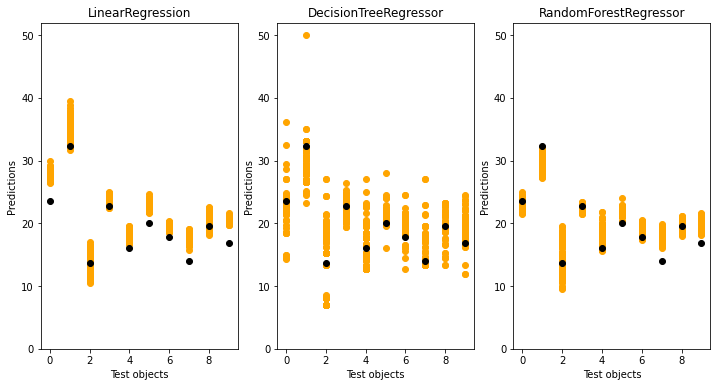

In [146]:
plt.figure(figsize=(12, 6)) 

plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, title='LinearRegression')

plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, title='DecisionTreeRegressor')

plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, title='RandomForestRegressor')

plt.show()

__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Для линейной регрессии предсказания (оранжевые точки) не далеко друг от друга, это значит, что там маленький разброс. Но черные точки иногда вылезают из предсказаний, что говорит о большом смещении

Для решающего дерева предсказания находятся далековато друг от друга, что говорит о большем разбросе. Но черные точки попадают в предсказания, что говорит о маленьком смещении

Для случайного леса ситуцаия хорошая. Здесь разброс меньше, чем у дерева, но чуть побольше, чем у лин рега. Смещение чуть хуже, чем у дерева, но явно лучше, чем у лин рега. Это лучший алгоритм из этих

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [151]:
all_biases = []
all_variance = []
for depth in range(1, 11):
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_depth=depth), X, y)
    all_biases.append(bias)
    all_variance.append(variance)



In [152]:
bias_feaut = []
feaut_variance = []
for feaut in range(1, X.shape[1]):
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_features=feaut), X, y)
    bias_feaut.append(bias)
    feaut_variance.append(variance)

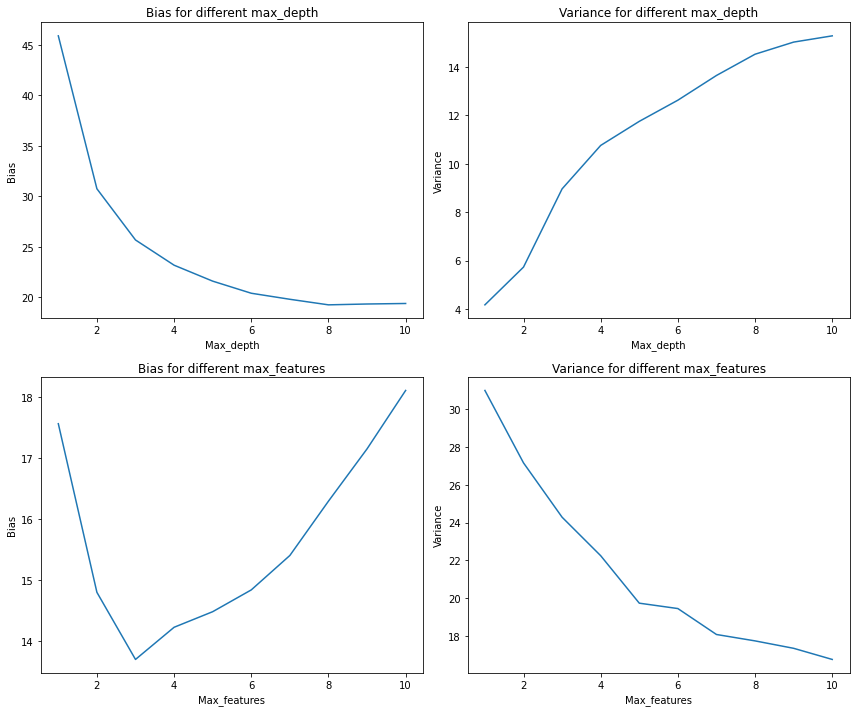

In [153]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, 11), all_biases)
plt.title('Bias for different max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Bias')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(range(1, 11), all_variance)
plt.title('Variance for different max_depth')
plt.xlabel('Max_depth')
plt.ylabel('Variance')
plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(range(1, X.shape[1]), bias_feaut)
plt.title('Bias for different max_features')
plt.xlabel('Max_features')
plt.ylabel('Bias')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(range(1, X.shape[1]), feaut_variance)
plt.title('Variance for different max_features')
plt.xlabel('Max_features')
plt.ylabel('Variance')
plt.tight_layout()

plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [157]:
from sklearn.ensemble import GradientBoostingRegressor

bias_random_forest = []
variance_random_forest = []
bias_boosting = []
variance_boosting = []

for n_estimatorstor in 2**np.arange(1, 10):
    bias, variance, error = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimatorstor), X, y)
    bias_random_forest.append(bias)
    variance_random_forest.append(variance)

    bias, variance, error = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimatorstor), X, y)
    bias_boosting.append(bias)
    variance_boosting.append(variance)

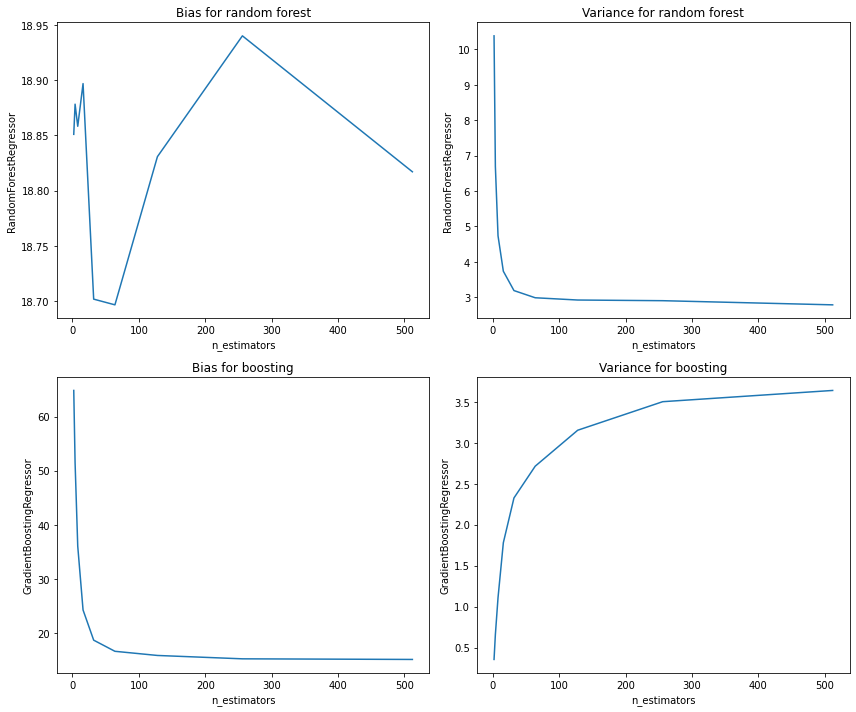

In [159]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(2**np.arange(1, 10), bias_random_forest)
plt.title('Bias for random forest')
plt.xlabel('n_estimators')
plt.ylabel('RandomForestRegressor')
plt.tight_layout()

plt.subplot(2, 2, 2)
plt.plot(2**np.arange(1, 10), variance_random_forest)
plt.title('Variance for random forest')
plt.xlabel('n_estimators')
plt.ylabel('RandomForestRegressor')

plt.tight_layout()

plt.subplot(2, 2, 3)
plt.plot(2**np.arange(1, 10), bias_boosting)
plt.title('Bias for boosting')
plt.xlabel('n_estimators')
plt.ylabel('GradientBoostingRegressor')
plt.tight_layout()

plt.subplot(2, 2, 4)
plt.plot(2**np.arange(1, 10), variance_boosting)
plt.title('Variance for boosting')
plt.xlabel('n_estimators')
plt.ylabel('GradientBoostingRegressor')

plt.tight_layout()

plt.show()

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Первые 4 графика:

Bias for different max_depth:

При увеличении глубины дерева смещение уменьшается, это связано с тем, что более глубокие деревья имееют более сложную модель, в результате чего смещение становится меньше

Variance for different max_depth:

При увеличении глубины разброс увеличивается, это логично, так как модель начинает больше подстраиваться под обучающую выборку


Bias for different max_features:

Смещение сначала уменьшается, а затем увеличивается. Если признаков слишком мало, то могут не найтись нужные закономерности в модели, а когда признаков очень много, то она начинает учиться на неважных признаках. То есть смещению важны только важные признаки

Variance for different max_features:

При увеличении количества признаков разброс уменьшается, это значит, что молель находит разбиение лучше при достаточном количестве разбиений и модели начинают быть схожи

Вторые 4 графика:

Bias for random forest:

Здесь происходят колебания, в начале есть рост из-за нехватки моделей, потом смещение снижается при нормальном количестве деревьев. А затем происходит переобучение

Variance for random forest:

Разброс сначала резко уменьшается, потом начинает принимать примерно одинаковое значение. Большое количество деревьев уменьшает разброс, но с какого-то момента он перестает меняться


Bias for boosting:

Смещение сначала резко уменьшается при увеличении n_estimator, потом начинает принимать примерно одинаковое значение. Бустинг хорошо снижает смещение, особенно в начале, когда происходит корректировка ошибок предыдущих моделей

Variance for boosting:

Разброс медленно увелечивается, так как модель становится более чуствительная к train выборке. Я думаю здесь произощло обучение, об этом на говорят 2 последних графика

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

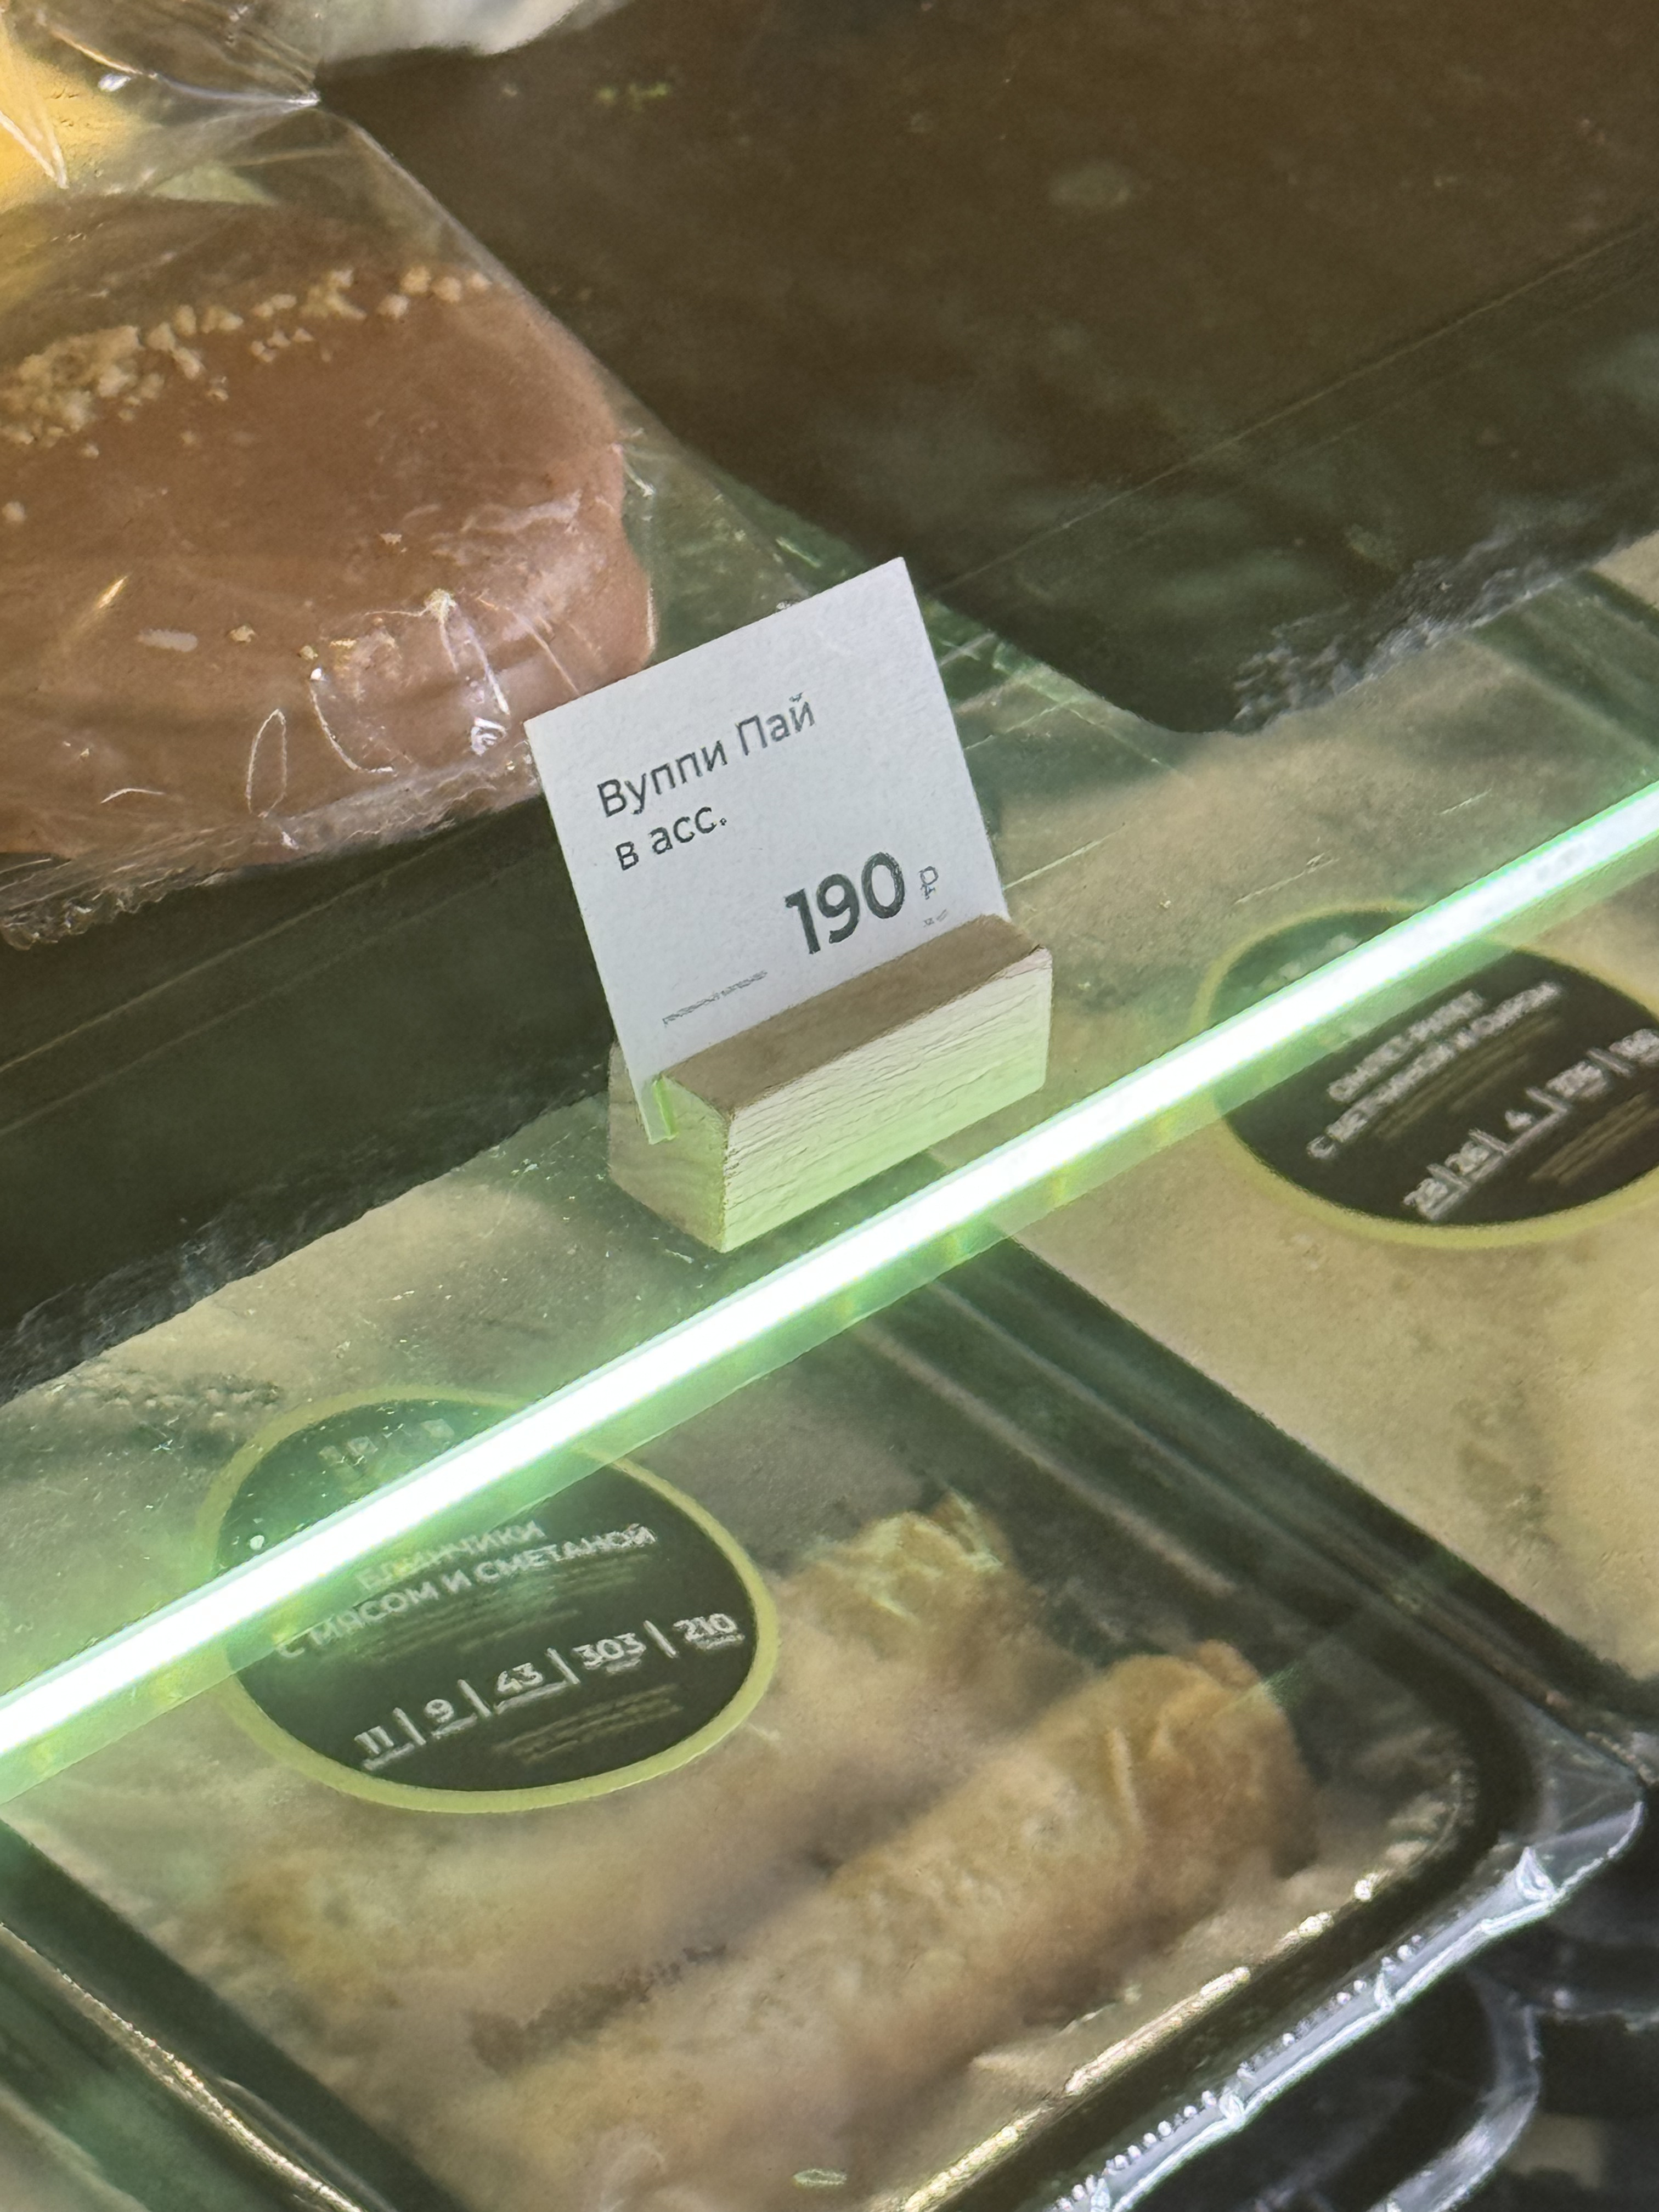

Примерно вот так меня встретил декабрь( 

Прям в самую асс